<a href="https://colab.research.google.com/github/dastuzh/M49-FDS20/blob/master/Practical_1_Files_Anic_Haller/Practical1_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 1 : Implementation of Linear Regression (Ridge, Lasso)

First part:
- Implement linear regression model 
    - using least squares method
    - implement directly using the NumPy package

Second part:
- regularization
- polynomial basis expansion
- cross validation
- scikit-learn: https://scikit-learn.org/

You will need to use the following:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cp

For the purpose of testing, we’ll use the winequality dataset. The dataset is available here:
https://archive.ics.uci.edu/ml/datasets/Wine+Quality In order to make it easier to import the dataset, we’ve converted the data to the numpy array format and shuffled it so that you can start the practical directly. The dataset is available on the course website. 

The dataset has two files. We’ll focus on the white wine data, which is the larger dataset. You can load the data from the files as follows:

In [4]:
# load the dataset
# X is a matrix such that each row stores a data record 
# y is a vector of the corresponding labels of the records
X, y = cp.load(open('winequality-white.pickle', 'rb'))

# check the size of the data
print("X is a matrix with shape {}, which has {} records and {} attributes.".format(X.shape, X.shape[0], X.shape[1]))
print("y is a vector with {} values, which stores the corresponding labels of the data records in X".format(y.shape[0]))

X is a matrix with shape (4898, 11), which has 4898 records and 11 attributes.
y is a vector with 4898 values, which stores the corresponding labels of the data records in X


In order to get consistent results, all students should use the same 80% of the data as training
data. We’ll use the remaining as test data. To achieve this split run the following:

In [5]:
# The function splits the dataset into the training dataset and the test dataset.
# The parameter split_coeff is a percentage value such that
# the first split_coeff of the dataset goes to the training dataset, 
# and the remaining data goes to the test dataset.
def split_data(X, y, split_coeff):
    N, _ = X.shape # get the number of records (rows)
    train_size = int(split_coeff * N) # use the first split_coeff of the data as the training data
    X_train = X[:train_size] # the first training_size records
    y_train = y[:train_size]
    X_test = X[train_size:] # the last test_size records
    y_test = y[train_size:]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_data(X, y, 0.8) # use 80% of the data as training data

# check the size of the splitted dataset
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (3918, 11)
Shape of y_train: (3918,)
Shape of X_test: (980, 11)
Shape of y_test: (980,)


We’ll not touch the test data except for reporting the errors of our learned models

## Understanding What We’re Predicting

Before we get to training a linear model on the data and using it to make predictions, let’s look
at the spread of y values on the training set. The values are integers between 3 and 9 indicating
the quality of the wine.


### **Task 1**
Make a bar chart showing the distribution of y values appearing in the training data.

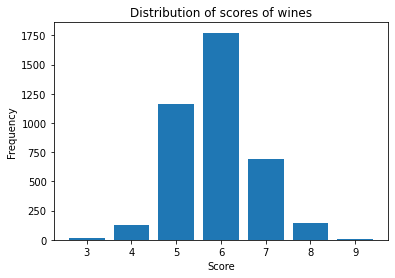

In [6]:
#@title
# Task 1: 
# the function takes the training dataset as the input, and make the bar chart
def plot_bar_chart_score(X_train, y_train):
  plt.title("Distribution of scores of wines") # add title
  plt.xlabel("Score") # add x axis caption
  plt.ylabel("Frequency") # add y axis caption
  labels, counts = np.unique(y_train, return_counts=True) # get the unique values of y and the counts for each of them
  plt.bar(labels, counts, align='center') # create the bar chart
  plt.gca().set_xticks(labels) # set the labels of the ticks on the x axis
  plt.show()
plot_bar_chart_score(X_train, y_train)

### **Task 2** 
Implement the trivial predictor, which uses the average value of y on the training set as the prediction for ever datapoint. 

In [7]:
#@title
# Task 2: implement the simplest predictor
# The function computes the average value of y on the training label values
def compute_average(y_train):
  return np.mean(y_train)

y_train_avg = compute_average(y_train)
print("Average of y on the training label values is {}".format(y_train_avg))

# The simplest predictor returns the average value.
def simplest_predictor(X_test, y_train_avg):
  return y_train_avg

Average of y on the training label values is 5.878764675855028


### **Task 3**
Report the mean squared error, i.e., the average of the squared residuals, using this simplest of predictors on the training and test data. We should hope that our models beat at lease this baseline. 

In [8]:
# We will evaluate our simplest predictor here. 
# Implement a function that can report the mean squared error 
# of a predictor on the given test data
# Input: test dataset and predictor
# Output: mean squared error of the predictor on the given test data
def test_data(X_test, y_test, predictor: callable=None):
    # Applies the predictor to each row to compute the predicted values
    y_predicted = np.apply_along_axis(predictor, 1, X_test)
    # Compte the error for each observation
    errors = y_test - y_predicted
    # Compute the sum of squared errors and divide it by the number of observations
    mse = (errors.T @ errors)/X_test.shape[0]
    return mse

# use the above function test_data to evaluate the simplest predictor
# we use the lambda function here to pass the function simplest_predictor to the evaluator.
mse_simplest_predictor_train = test_data(X_train, y_train, lambda x: simplest_predictor(x, y_train_avg))
mse_simplest_predictor_test = test_data(X_test, y_test, lambda x: simplest_predictor(x, y_train_avg))

# Report the result
print('Simplest Predictor')
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_simplest_predictor_train)
print('MSE (Testing)  = %.4f' % mse_simplest_predictor_test)

Simplest Predictor
--------------------------------------------------------------------------------

MSE (Training) = 0.7768
MSE (Testing)  = 0.8139


## Linear Model Using Least Squares

Let us first fit a linear regression model and then calculate the training and test error. We’ll
actually use the closed form solution of the least squares estimate for the linear model. 


### **Task 4**
Is it strictly necessary to standardize the data for the linear model using the least squares method? Why?

**Answer:** 

No, for the standard least squares method (without regularization) it is not stricly necessary. The ordinary least squares method essentially returns estimates, which measure the correlation between $x_k$ and $y$ with normalized units - meaning that the correlation is multiplied by the following ratio: standard deviation of $y$ / standard deviation of the $x_k$. Hence, standardizing the data just leads to rescaled parameters, such that the estimated coefficients represent the correlations between $x_k$ and $y$ in units of the standard deviation of $y$. However, transforming the estimated coefficients back after the model estimation (to get conveniently interpretable coefficients) would lead to the exact same results as estimating the model directly without standardizing the data.

In contrast, as soon as we add a regularization term, it is important to standardize the data such that each estimate is equally strong regularized. Estimating a regularized model directly with the unstandardized data would lead to a stronger regularization for features with comparatively small standard deviations. Hence, we standardize the inputs to avoid this dependency on scaling.

### **Task 5**
Standardize the data, i.e., make the data for every feature have mean 0 and variance 1. 

We do the standardization using the training data, and we need to remember the means and
the standard deviations so that they can be applied to the test data as well. Apply the
standardization so that every feature in the training data has mean 0 and variance 1. Apply
the same transformation to the test data. 

In [9]:
# Input: training data
# Output: standardize training data, standard deviations and means
def standardize_data(X):
    # Compute the mean
    mean = np.mean(X, axis=0)
    # Compute the standard deviation
    std = np.std(X, axis=0)
    # Standardize the data
    X_std = (X - mean)/std  
    # Return the desired variables
    return X_std, mean, std

X_train_std, X_train_mean, X_train_std_div = standardize_data(X_train)
print("X_train_std:", X_train_std.shape)
print("Mean:", X_train_mean)
print("Standard deviation:", X_train_std_div)

X_train_std: (3918, 11)
Mean: [6.85427514e+00 2.78390761e-01 3.34892802e-01 6.42623788e+00
 4.58213374e-02 3.53263144e+01 1.38513272e+02 9.94040729e-01
 3.18647524e+00 4.89055641e-01 1.05115799e+01]
Standard deviation: [8.39100902e-01 9.95630176e-02 1.24249975e-01 5.06377532e+00
 2.16660282e-02 1.71004677e+01 4.23956179e+01 2.97972269e-03
 1.49949475e-01 1.12992053e-01 1.22536544e+00]


In [10]:
# Standardize the test data using the mean and standrad deviation you computed for the training data
X_test_std = (X_test-X_train_mean)/X_train_std_div
print(X_test_std.shape)

(980, 11)


### **Task 6**
Implement the linear model predictor, and report the mean squared error using the linear model on the training and test data.

We will do this in several steps. We need to implement the function for computing the parameters based on the training dataset. Note we need to add the bias column to the dataset. 

In [11]:
# the function adds a column of ones to the front of the input matrix
def expand_with_ones(X):
    # Create a one dimensional array of ones with length equal to the number of rows in X (i.e. N)
    Const = np.repeat(1, X.shape[0])
    # Add a column dimension to the array of ones, such that its dimension is (N,1)
    Const = np.expand_dims(Const, axis=1)
    # Add the column of ones to X and save it into X_out
    X_out = np.append(Const, X, axis=1)
    return X_out

# The function computes the parameters
def least_squares_compute_parameters(X_input, y):
    # add the bias column to the dataset
    X = expand_with_ones(X_input)
    # Calculate the OLS parameters using (X'X)^(-1)X'y
    T = np.linalg.inv(X.T @ X) @ X.T @ y
    T = np.asarray(T)
    return T

# train the linear model parameters
w = least_squares_compute_parameters(X_train_std, y_train) 
print("w:", w.shape)

w: (12,)


We then implement the linear model predictor given the dataset and the parameters. 

In [12]:
# Implement the linear model predictor
# Input: test data and parameters
# Output: predicted values
def linear_model_predictor(X, w):
    # Compute the predicted values based on the test dataset and the parameters
    y_predicted = X @ w
    return y_predicted

We can now evaluate our linear model predictor on the test dataset. 

In [13]:
# use the function test_data to evaluate the linear model predictor
mse_linear_model_predictor = test_data(expand_with_ones(X_test_std), y_test, lambda x: linear_model_predictor(x, w))
print("Mean squared error is {}".format(mse_linear_model_predictor))

Mean squared error is 0.5607292042283473


## Learning Curves

Let us see if the linear model is overfitting or underfitting. Since the dataset is somewhat large and there are only 11 features, our guess should be that it may either be underfitting or be about right.

Starting with 20 datapoints, we’ll use training datasets of increasing size, in increments of 20 up to about 600 datapoints. For each case train the linear model only using the first n elements of
the training data. Calculate the training error (on the data used) and the test error (on the full test set). Plot the training error and test error as a function of the size of the dataset used for
training.

### **Task 7** 
Implement a function that evaluates the linear model over the training dataset with the input size.
The function takes a dataset and the split coefficient as inputs, and
1. splits the data to training and test datasets,
2. standardizes the data,
3. trains the linear model, and
4. reports the mse of the linear model predictor on both training and test datasets. 

In [14]:
# Input: dataset and split coefficient
# Output: mse of the linear model predictor on both the training and test datasets
def train_and_test(X, y, split_coeff):
    ## 1. Split the data into training and test dataset
    X_train, y_train, X_test, y_test = split_data(X, y, split_coeff)
    ## 2. Standardize the data
    # Start by standardizing the training data
    X_train_std, X_train_mean, X_train_std_div = standardize_data(X_train)
    # Then standardize the test data using the mean and standrad deviation we computed for the training data
    X_test_std = (X_test-X_train_mean)/X_train_std_div
    ## 3. Train the linear model
    w = least_squares_compute_parameters(X_train_std, y_train)
    ## 4. Report the mse of the linear model predictor on both training and test datasets
    mse_train = test_data(expand_with_ones(X_train_std), y_train, lambda x: linear_model_predictor(x, w))
    mse_test  = test_data(expand_with_ones(X_test_std), y_test, lambda x: linear_model_predictor(x, w))
    return mse_train, mse_test

mse_train, mse_test = train_and_test(X, y, 0.8)
print('MSE using Linear Models')
print('-----------------------\n')
print('MSE (Training) = %.4f' % mse_train)
print('MSE (Testing)  = %.4f' % mse_test)


MSE using Linear Models
-----------------------

MSE (Training) = 0.5640
MSE (Testing)  = 0.5607


### **Task 8**
Report the learning curves plot. Also, explain whether you think the model is underfitting or not and how much data you need before getting the optimal test error.

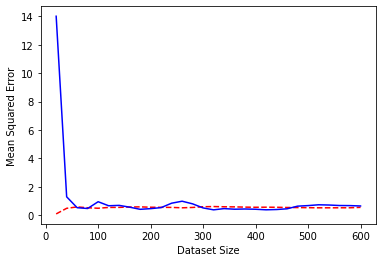

In [15]:
mse_train_v = []
mse_test_v = []

TRAINING_SIZE_MAX = 601
TRAINING_SIZE_MIN = 20

# compute the errors over datasets with different sizes
for train_size in range(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20):
    # Select the first train_size elements of the data as the dataset to use for the estimation
    X_use = X[:train_size]
    y_use = y[:train_size]
    # Use the above defined function to calculate the training error and test error
    mse_train, mse_test = train_and_test(X_use, y_use, 0.8)
    # Add them to mse_train_v and mse_test_v, respectively
    mse_train_v.append(mse_train)
    mse_test_v.append(mse_test)

# The below code outputs the plot of mse from different training sizes
plt.figure(2)
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_train_v, 'r--', label="Training Error")
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_test_v, 'b-', label="Test Error")
plt.xlabel('Dataset Size')
plt.ylabel('Mean Squared Error')
plt.show()

We observe that the test error is very large for small dataset sizes, but then decreases very fast with an increasing dataset size until it reaches a similar level as the training error at a dataset size of 60 observations. The large difference between the test error and training error (with test error >> training error) we observe for small dataset sizes definitely indicates that the model is underfitting. However, since the test error reaches a similar level as the training error as soon as the dataset size is 60 or larger, we conclude that the minimum amount of data needed to get an "optimal" test error (i.e. a test error similar to the train error) is approximately 60. Note that having larger datasets than 60 does not affect the test error significantly.

## Polynomial Basis Expansion with Ridge and Lasso

For this part use the following from the scikit-learn package. Read the documentation available here: http://scikit-learn.org/stable/modules/classes.html



You will need the use the following:

In [16]:
# You will need the following libs. 
# Fell free to import other libs. 

# import the preprocessing libs for standarization and basis expansion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 

# Ridge and Lasso linear model
from sklearn.linear_model import Ridge, Lasso 

Try 5 powers of 10 for lambda from 10^-2 to 10^2 and use degree 2 basis expansion. Fit ridge and lasso using degree 2 polynomial expansion with these values of lambda. You should pick the optimal values for lambda using a validation set. Set the last 20% of the training set for the purpose of validation.

### **Task 9**
Let's implement the function for expanding the basis of the dataset. 

Hints: use `PolynomialFeatures`

In [17]:
def expand_basis(X, degree):
    # Expand the basis of X for the degree by means of the PolynomialFeatures function
    # Note that we exclude the bias term. This is done to prevent problems when standardizing the data later on
    poly = PolynomialFeatures(degree = degree, include_bias = False)
    X = poly.fit_transform(X)
    return X

### **Task 10**
Prepare the training, test and validation data using the expanded dataset. Expand and standardize the data. 

Hints: you can use `StandardScaler` and `std_scaler` to standardize the data

In [18]:
# TODO: the training, test and validation data using the expanded dataset.
# The code below is just for compilation. 
# You need to replace it by your own code.
def prepare_data(X, y, degree):
    # Expand the basis of X
    X = expand_basis(X, degree)
    # Split the data into training and test dataset with a split coefficient of 0.8
    X_train, y_train, X_test, y_test = split_data(X, y, 0.8)
    # Standardize the training data
    X_train_std, X_train_mean, X_train_std_div = standardize_data(X_train)
    # Standardize the test data by the same transformation
    X_test_std = (X_test - X_train_mean)/X_train_std_div
    # Further split the training data to training and validation data with a split coefficient of 0.8
    X_train_n, y_train_n, X_train_v, y_train_v = split_data(X_train_std, y_train, 0.8)
    # Standardize X_train_n
    X_train_n_std, X_train_n_mean, X_train_n_std_div = standardize_data(X_train_n)
    # Apply the same transformation to the validation set
    X_train_v_std = (X_train_v - X_train_n_mean)/X_train_n_std_div    

    # Return the prepared datasets
    return X_train_std, y_train, X_train_n_std, y_train_n, X_train_v_std, y_train_v, X_test_std, y_test


X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test = prepare_data(X, y, 2) # here we expand the dataset with degree 2

### **Task 11**
We have prepared the training data and the validation data. We can now choose the hyper parameter lambda for Ridge and Lasso using the validation data. 


Ridge lambda: 0.01
Lasso lambda: 0.01


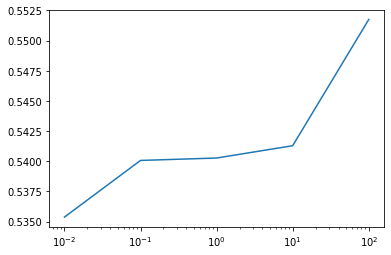

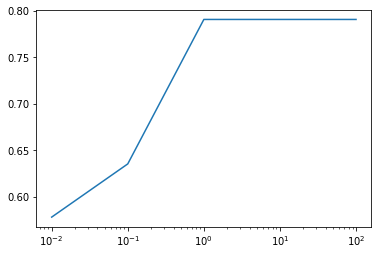

In [19]:
# The function takes the training and validation data as inputs, and 
# returns the lambda value that has the minimal mse
# We use is_ridge to indicate the model we consider. 
# is_ridge = True indicates Ridge while is_ridge = False indicates Lasso
def choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, is_ridge: bool):
    mse_arr = []
    lam_arr = []

    for pow_lam in range(-2, 3):
        lam = 10 ** pow_lam
        # Specify the model depending on the bool variable is_ridge
        if(is_ridge):
          model = Ridge(lam).fit(X_train_n, y_train_n)
        else:
          model = Lasso(lam).fit(X_train_n, y_train_n)
        # Get the predictions for the validation set
        y_pred = model.predict(X_train_v)
        # Calculate the mse
        mse = np.sum((y_pred - y_train_v) ** 2) / y_train_v.shape[0]
        # Add the mse when using the hyperparameter lam
        mse_arr.append(mse) 
        lam_arr.append(lam)

    # get the index of the lambda value that has the minimal mse
    lambda_idx_min = np.argmin(np.array(mse_arr))

    # plot of the lambda values and their mse
    plt.figure()
    plt.semilogx(lam_arr, mse_arr)

    # return the best lambda value
    return lam_arr[lambda_idx_min]

# call the function to choose the lambda for Ridge and Lasso
lam_ridge = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, True)
lam_lasso = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, False)

print("Ridge lambda:", lam_ridge)
print("Lasso lambda:", lam_lasso)

### **Task 12**:
Once you’ve obtained the optimal values for lambda for Ridge and Lasso, train these models using these hyperparameters on the full training data. Then report
the training and test error.

In [20]:
## Ridge
# Train the ridge model using the best lambda from above
model = Ridge(lam_ridge).fit(X_train, y_train)
# Get the predictions for the training set and test set
y_train_pred_r = model.predict(X_train)
y_test_pred_r  = model.predict(X_test)
# Calculate the training mse and test mse
mse_ridge_train = np.sum((y_train_pred_r - y_train) ** 2) / y_train.shape[0]
mse_ridge_test  = np.sum((y_test_pred_r - y_test) ** 2) / y_test.shape[0]

## Lasso
# Train the lasso model using the best lambda from above
model = Lasso(lam_lasso).fit(X_train, y_train)
# Get the predictions for the training set and test set
y_train_pred_l = model.predict(X_train)
y_test_pred_l  = model.predict(X_test)
# Calculate the training mse and test mse
mse_lasso_train = np.sum((y_train_pred_l - y_train) ** 2) / y_train.shape[0]
mse_lasso_test  = np.sum((y_test_pred_l - y_test) ** 2) / y_test.shape[0]


# Report the result
print('For Ridge Regression with using degree %d polynomial expansion and lambda = %.4f' % (2, lam_ridge))
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_ridge_train)
print('MSE (Testing)  = %.4f' % mse_ridge_test)

print('\n\nFor Lasso with using degree %d polynomial expansion and lambda = %.4f' % (2, lam_lasso))
print('---------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_lasso_train)
print('MSE (Testing)  = %.4f' % mse_lasso_test)

For Ridge Regression with using degree 2 polynomial expansion and lambda = 0.0100
--------------------------------------------------------------------------------

MSE (Training) = 0.5014
MSE (Testing)  = 0.5161


For Lasso with using degree 2 polynomial expansion and lambda = 0.0100
---------------------------------------------------------------------

MSE (Training) = 0.5489
MSE (Testing)  = 0.5422


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6575181351659012, tolerance: 0.3043413221031145
  positive)


## Larger Degrees



### **Task 13**
Try using higher degree basis expansion. You may want to use k-fold cross validation to determine
the values of hyperparameters rather than just keeping a validation set. 

Hints: Use `KFold` to do this automatically. 

For Ridge Regression the lowest MSE is obtained using a degree 3 polynomial expansion and lambda = 10.00
For Lasso the lowest MSE is obtained using a degree 7 polynomial expansion and lambda = 0.01


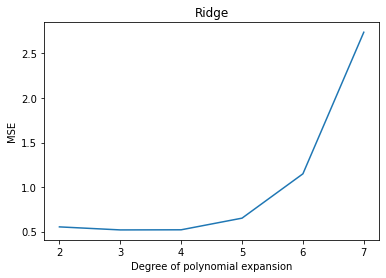

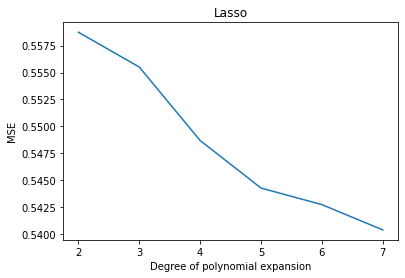

In [21]:
# KFold
from sklearn.model_selection import KFold
# Suppress the convergence warnings which occure when a lasso is fitted
import warnings
warnings.filterwarnings("ignore")

# Define a function that returns the best degree for the basis expansion
# together with the associated best lambda
def Kfold_hyper_param_and_exp_deg(X, y, maxdeg, K, is_ridge: bool):
  # Create variables to store the best lambda and the according mse 
  # for each degree of basis expansion
  mse_arr = []
  lam_arr = []
  deg_arr = []
  # Set up a K-fold cross validation
  kf = KFold(n_splits = K)

  for deg in range(2, maxdeg+1):
    X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test = prepare_data(X, y, deg)
    # Create variables to store the lambda and mse for each basis expansion of X
    mse_deg_arr = []
    lam_deg_arr = []

    # Estimate K models for each lambda and choose the lambda that 
    # leads to the lowest average mse among the K models
    for pow_lam in range(-2, 3):
      lam = 10 ** pow_lam
      # Create a variable to store the mse of each K estimation
      mse_fold_arr = []

      # Estimate the model for all K splits
      for train_index, valid_index in kf.split(X_train):
        X_train_n = X_train[train_index]
        y_train_n = y_train[train_index]
        X_train_v = X_train[valid_index]
        y_train_v = y_train[valid_index]
        # Specify the model depending on the bool variable is_ridge
        if(is_ridge):
          model = Ridge(lam).fit(X_train_n, y_train_n)
        else:
          model = Lasso(lam).fit(X_train_n, y_train_n)
        # Get the predictions for the validation set
        y_pred = model.predict(X_train_v)
        # Calculate the mse
        mse = np.sum((y_pred - y_train_v) ** 2) / y_train_v.shape[0]
        # Add the mse when using the hyperparameter lam
        mse_fold_arr.append(mse)

      # Get the average mse obtained when using hyperparameter lam
      mse_avg = np.mean(mse_fold_arr)
      # Add the average mse when using the hyperparameter lam
      mse_deg_arr.append(mse_avg)
      lam_deg_arr.append(lam)

    # Get the index of the lambda value that has the minimal average mse
    lambda_idx_min = np.argmin(np.array(mse_deg_arr))
    # For each degree of basis expansion store the degree, the best lambda and
    # the associated mse
    lam_arr.append(lam_deg_arr[lambda_idx_min])
    mse_arr.append(mse_deg_arr[lambda_idx_min])
    deg_arr.append(deg)

  # Get the index of the degree of basis expansion that has the minimal mse
  deg_idx_min = np.argmin(np.array(mse_arr))
  # Report the best degree of basis expansion and the associated lambda
  if(is_ridge):
    print('For Ridge Regression the lowest MSE is obtained using a degree %d polynomial expansion and lambda = %.2f' % (deg_arr[deg_idx_min], lam_arr[deg_idx_min]))
    title = "Ridge"
  else:
    print('For Lasso the lowest MSE is obtained using a degree %d polynomial expansion and lambda = %.2f' % (deg_arr[deg_idx_min], lam_arr[deg_idx_min]))
    title = "Lasso"
  # Plot the degrees of basis expansion versus their mse
  plt.figure()
  plt.plot(deg_arr, mse_arr)
  plt.title(title)
  plt.xticks(range(2, maxdeg+1))
  plt.xlabel("Degree of polynomial expansion")
  plt.ylabel("MSE")
  # Return the best degree of basis expansion and the associated lambda
  return deg_arr[deg_idx_min], lam_arr[deg_idx_min]

# Call the function to choose the degree of basis expansion and the associated
# lambda for Ridge and Lasso
deg_ridge, lam_ridge = Kfold_hyper_param_and_exp_deg(X, y, 7, 10, True)
deg_lasso, lam_lasso = Kfold_hyper_param_and_exp_deg(X, y, 7, 10, False)

Once we’ve obtained the optimal degree for the basis expansion and the associated lambda values for Ridge and Lasso, we train these models using these degrees of basis expansion and the associated hyperparameters on the full training data. Then we report the training and test errors.

In [22]:
## Ridge
# Prepare the dataset using the best degree of basis expansion from above
X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test = prepare_data(X, y, deg_ridge)
# Train the Ridge model using the best lambda from above
model = Ridge(lam_ridge).fit(X_train, y_train)
# Get the predictions for the training set and test set
y_train_pred_r = model.predict(X_train)
y_test_pred_r  = model.predict(X_test)
# Calculate the training mse and test mse
mse_ridge_train = np.sum((y_train_pred_r - y_train) ** 2) / y_train.shape[0]
mse_ridge_test  = np.sum((y_test_pred_r - y_test) ** 2) / y_test.shape[0]

## Lasso
# Prepare the dataset using the best degree of basis expansion from above
X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test = prepare_data(X, y, deg_lasso)
# Train the Lasso model using the best lambda from above
model = Lasso(lam_lasso).fit(X_train, y_train)
# Get the predictions for the training set and test set
y_train_pred_l = model.predict(X_train)
y_test_pred_l  = model.predict(X_test)
# Calculate the training mse and test mse
mse_lasso_train = np.sum((y_train_pred_l - y_train) ** 2) / y_train.shape[0]
mse_lasso_test  = np.sum((y_test_pred_l - y_test) ** 2) / y_test.shape[0]


## Report the result
print('For Ridge Regression with using a degree %d polynomial expansion and lambda = %.2f we obtain the following training and test MSE' % (deg_ridge, lam_ridge))
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_ridge_train)
print('MSE (Testing)  = %.4f' % mse_ridge_test)

print('\n\nFor Lasso with using a degree %d polynomial expansion and lambda = %.2f we obtain the following training and test MSE' % (deg_lasso, lam_lasso))
print('---------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_lasso_train)
print('MSE (Testing)  = %.4f' % mse_lasso_test)


For Ridge Regression with using a degree 3 polynomial expansion and lambda = 10.00 we obtain the following training and test MSE
--------------------------------------------------------------------------------

MSE (Training) = 0.4738
MSE (Testing)  = 0.5199


For Lasso with using a degree 7 polynomial expansion and lambda = 0.01 we obtain the following training and test MSE
---------------------------------------------------------------------

MSE (Training) = 0.5178
MSE (Testing)  = 0.5232


## **Report**

In this report, we will give the reader information about the way we approached the pracical, which steps were done throughout which period, how we organised feedback and progress determination and give our assessment on our style of cooperation. 

As this was our first practical in a subject with an informatics background, we deemed it necessary that each member first looked at the theoretical part on their own before diving into the actual problem solving exercise. Within this period, we simply gathered theoretical knowledge about the subject and assembled steps as to how the Problem Set might be solved in an efficient manner, both from a conceptual as well as programming-based background. If any questions arose, we then communicated them and solved them together on a day-to-day basis. We then started the practical on an individual basis, as we had both a different schedule (which is why the members had time in different weeks) and due to the fact that we both wanted to thoroughly understand the concepts and approaches of the first Problem Set. As such, we continued working on the Set on our own and had a couple of meetings to discuss the progress, compare preliminary results and define the further targets. Interestingly, we had a quite similar way of retrieving the solutions, implying that we did not encounter a great heterogeneity in both programming approach as well as the obtained solutions. The largest difficulty was based on the last exercise, which required us to write a longer code than previously expected. As it is the first time for us using Python (normally, we're R users), the initial handling of the code was messy and unclear. However, through individual approaches, the group was then able to solve the matter at hand to a degree which was satisfactory. We finished the Practical 1 around mid-October by having a last feedback round in which we went over the code together, assessed the efficiency of the commentaries made in the code (how understandable each step is described) and defined which style of code should be used. Regarding the cooperation, this is not the first project we worked on together. Both members share a similar mindset, both in work-ethic as well as in how we approach a problem. As such, cooperation was quite successful on a wide basis and did not encounter many frictions. Especially for this project, we were both able to grasp the effects and limitations the programs offer and get insights into how each step is computed. As a consequence, we both had a quite steep learning curve for the first project. The only thing that should be corrected for further projects is that we did not really use the "commit" method in github. This made it sometimes hard for the other members to pin down exactly where the progress of the project was. Also, we used sometimes different names of the directory for different files, which is why it was sometimes unclear which file of which member had the newest progress on. But apart from that, we understood that we can work together quite efficiently. 
